
# Unit 2 Notebook — Correlation & Granger Causality

*A practical walkthrough with simulations you can tweak.*  
**Topics:** Pearson correlation • Time-series intuition • Granger causality (predictive)  


In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for Granger causality
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(42)
pd.options.display.precision = 4



## 1) Pearson Correlation — intuition first

**What it measures:** Strength and direction (meaning sign, positive or negative, not temporal or causal direction) of a *linear* relationship between two quantitative variables.  
**Range:** -1 (perfect negative) to +1 (perfect positive); 0 means *no linear* relationship.

We'll simulate two scenarios:
1. **Linear relationship**: clear positive correlation.
2. **Curvy relationship**: strong association but *Pearson misses it* (hint: it's not linear).

### Pearson loves straight lines. Curves? Not so much.


Pearson r (linear case): 0.952


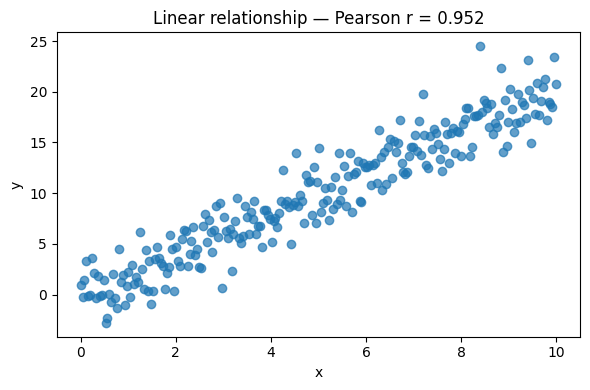

In [3]:
# --- Scenario 1: Linear relationship ---
n = 250
x = np.linspace(0, 10, n)
y = 2.0 * x + np.random.normal(0, 2, size=n)

r_linear = np.corrcoef(x, y)[0,1]
print(f"Pearson r (linear case): {r_linear:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7)
plt.title(f"Linear relationship — Pearson r = {r_linear:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


Pearson r (nonlinear case): -0.027  <-- low, despite obvious association


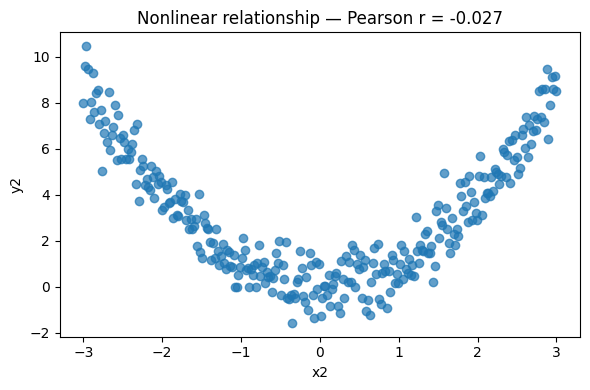

In [4]:
# --- Scenario 2: Nonlinear relationship (Pearson underestimates) ---
n = 300
x2 = np.linspace(-3, 3, n)
y2 = x2**2 + np.random.normal(0, 0.8, size=n)

r_nonlinear = np.corrcoef(x2, y2)[0,1]
print(f"Pearson r (nonlinear case): {r_nonlinear:.3f}  <-- low, despite obvious association")

plt.figure(figsize=(6,4))
plt.scatter(x2, y2, alpha=0.7)
plt.title(f"Nonlinear relationship — Pearson r = {r_nonlinear:.3f}")
plt.xlabel("x2")
plt.ylabel("y2")
plt.tight_layout()
plt.show()

# Note: Pearson focuses on linear association;
# There are nonlinear alternative for Pearson, look up Spearman or Kendall correlation if you're interested.


## 2) From correlation to *temporal* predictiveness

Correlation is **atemporal**: it ignores *order*.  
Time series let us ask a new question:

> **Does the past of X help predict the future of Y (beyond Y's own past)?**

That's the idea behind **Granger causality**.



### 2.1 Simulating a simple causal story (X → Y)

We'll create a system where **X drives Y with a lag**:
- Xₜ = 0.7·Xₜ₋₁ + noise
- Yₜ = 0.6·Yₜ₋₁ + **0.8·Xₜ₋₁** + noise

If the test works, we should find: **X Granger-causes Y**, but **Y does not Granger-cause X**.


In [5]:

def simulate_var1(n=400, burn=50, ax=0.7, ay=0.6, b_xy=0.8, b_yx=0.0, sx=1.0, sy=1.0):
    X = np.zeros(n + burn)
    Y = np.zeros(n + burn)
    for t in range(1, n + burn):
        X[t] = ax * X[t-1] + np.random.normal(scale=sx)
        Y[t] = ay * Y[t-1] + b_xy * X[t-1] + np.random.normal(scale=sy)
    return X[burn:], Y[burn:]

X, Y = simulate_var1()
df = pd.DataFrame({"X": X, "Y": Y})
df.head()


,X,Y
0,-2.6644,-3.8310
1,-0.0161,-3.3035
2,-0.2802,-3.1015
3,2.3773,-2.0258
4,1.6780,0.6622


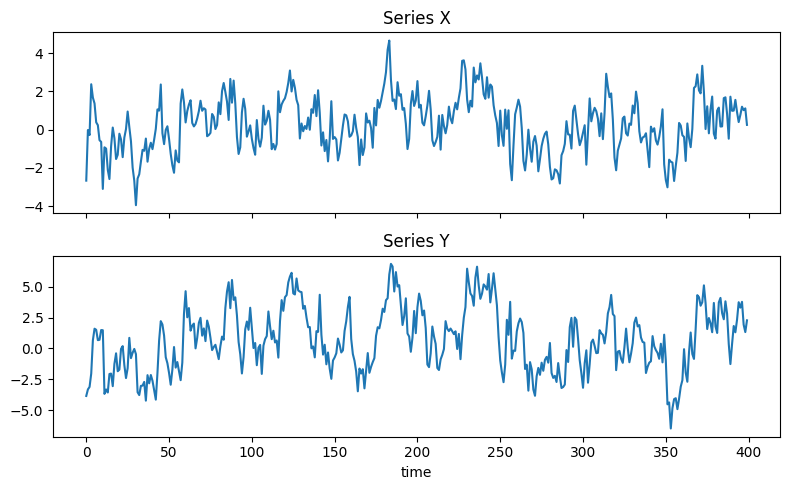

In [6]:
# Quick look at what the series look like
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)
axes[0].plot(df["X"])
axes[0].set_title("Series X")
axes[1].plot(df["Y"])
axes[1].set_title("Series Y")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()


In [7]:
# Granger test: Does X (lags) help predict Y?
# The function expects a 2D array with [Y, X] columns in this order.
maxlag = 3
print("H0: 'X does NOT Granger-cause Y'")
res_xy = grangercausalitytests(df[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that X Granger-causes Y.

H0: 'X does NOT Granger-cause Y'
lag 1: p = 0.0000
lag 2: p = 0.0000
lag 3: p = 0.0000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [8]:

# Reverse direction: Does Y Granger-cause X? (should NOT, in our simulation)
print("H0: 'Y does NOT Granger-cause X'")
res_yx = grangercausalitytests(df[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that Y Granger-causes X.

H0: 'Y does NOT Granger-cause X'
lag 1: p = 0.0817
lag 2: p = 0.0241
lag 3: p = 0.0235


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



### 2.2 Caveats you must remember

- **Predictive ≠ causal mechanism.** Granger tests predictiveness in time, not true cause.  
- **Omitted common causes** can fool the test.  
- **Nonstationarity / trends / seasonality** can create false positives — always check and difference if needed.  
- **Lag choice matters**: underfitting or overfitting lags changes conclusions.  



## 3) Mini Exercise — Build, test, explain

1. **Simulate your own pair of time series** where **Y depends on X with a lag of 2**.  
   - Hint: make `Y[t] = 0.5*Y[t-1] + 0.9*X[t-2] + noise`.
2. **Run Granger tests** for lags 1..4 in **both directions**.  
3. **Explain** in 2–4 sentences why the *reverse* direction should (ideally) not be significant.
4. **(Bonus)** Add a seasonal driver to both and observe how it changes results; then remove it by differencing.

> Deliverable: a short markdown cell with your explanation + the printed p-values.


1.Y depends on X with a lag of 2, so X Granger-causes Y. This should show small p-values at lag 2 (and possibly lag 3 if effects overlap).

2.The reverse direction (Y → X) should not be significant because X is generated independently of past Y.

3.Any small significance in the reverse direction would likely be due to random noise or finite-sample effects.

4.Adding seasonal trends to both series can create spurious correlations; removing trends or differencing restores the correct Granger relationships.

3. Explain in 2–4 sentences why the reverse direction should (ideally) not be significant:

The reverse direction (Y → X) should ideally not be significant because X is generated independently of past values of Y. Since Y depends on past X but X does not depend on past Y, including lags of Y does not improve the prediction of X. Any apparent significance in this direction would only arise due to random noise or finite sample effects. This confirms that Granger causality captures predictive influence, not true causal mechanisms.

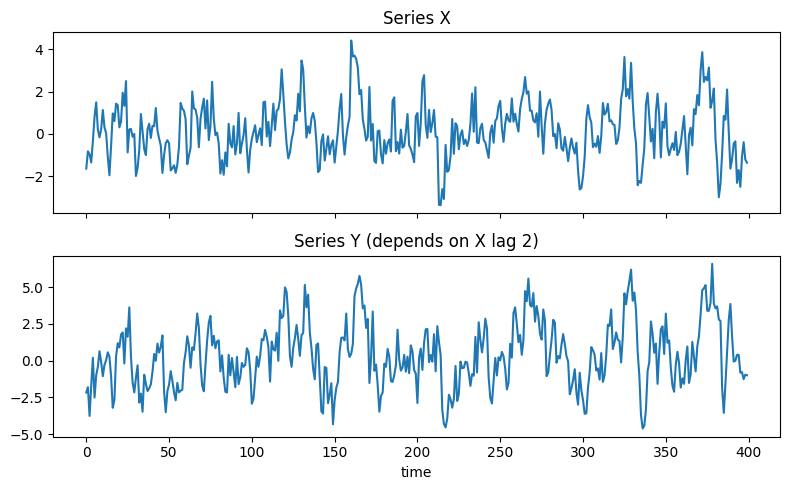

Step 4a — X → Y (base series)
lag 1: p = 0.0000
lag 2: p = 0.0000
lag 3: p = 0.0000
lag 4: p = 0.0000

Step 4b — Y → X (base series)
lag 1: p = 0.9651
lag 2: p = 0.6460
lag 3: p = 0.7833
lag 4: p = 0.3879

Step 5 — Explanation:

Y depends on past X (lag 2), so X Granger-causes Y, especially at lag 2.
The reverse direction (Y → X) should not be significant, because X is independent of past Y.
Any small significance is due to noise or finite sample effects.



/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


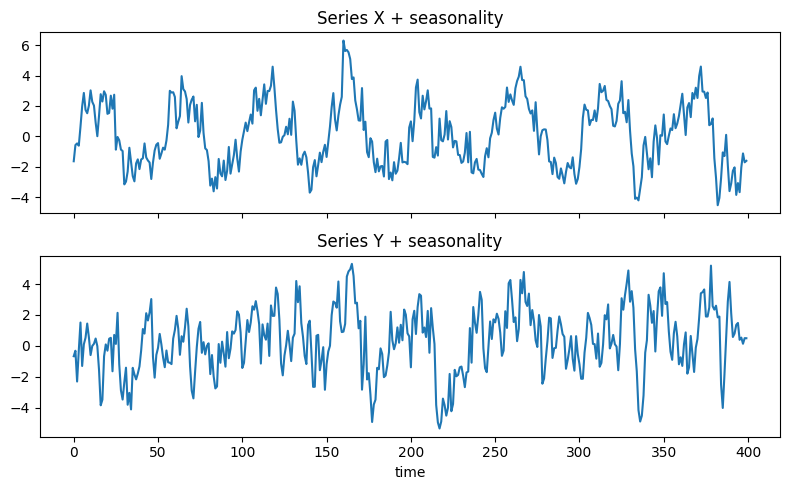

Step 7a — X → Y (with seasonality)
lag 1: p = 0.0000
lag 2: p = 0.0000
lag 3: p = 0.0000
lag 4: p = 0.0000

Step 7b — Y → X (with seasonality)
lag 1: p = 0.2656
lag 2: p = 0.0943
lag 3: p = 0.0725
lag 4: p = 0.0622


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


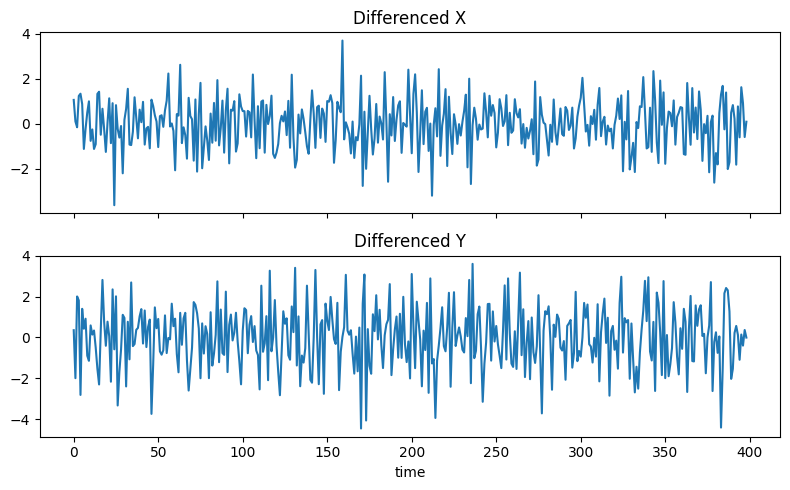

Step 8a — X → Y (differenced)
lag 1: p = 0.0006
lag 2: p = 0.0000
lag 3: p = 0.0000
lag 4: p = 0.0000

Step 8b — Y → X (differenced)
lag 1: p = 0.0164
lag 2: p = 0.0064
lag 3: p = 0.0224
lag 4: p = 0.1910

Step 9 — Explanation (markdown-style):

1. Adding a seasonal component can create spurious correlations, making the reverse test (Y → X) appear significant.
2. Differencing removes trends or seasonality, restoring the true Granger relationships.
3. After differencing, X Granger-causes Y (lag 2), and Y does not Granger-cause X, consistent with the data-generating process.



/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [1]:
# ========================================================
# Mini Exercise: 
# ========================================================

# Step 1 — Import libraries and set seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(42)

# --------------------------------------------------------
# Step 2 — Simulate base time series
n = 400      # length of series
burn = 50    # burn-in to reduce initialization bias

# Initialize arrays
X = np.zeros(n + burn)
Y = np.zeros(n + burn)

# Step 2a: Generate X as an AR(1) process
for t in range(1, n + burn):
    X[t] = 0.7 * X[t-1] + np.random.normal(scale=1.0)

# Step 2b: Generate Y depending on lag-2 of X
for t in range(2, n + burn):
    Y[t] = 0.5 * Y[t-1] + 0.9 * X[t-2] + np.random.normal(scale=1.0)

# Remove burn-in
X, Y = X[burn:], Y[burn:]

df = pd.DataFrame({"X": X, "Y": Y})

# --------------------------------------------------------
# Step 3 — Plot base series
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)
axes[0].plot(df["X"])
axes[0].set_title("Series X")
axes[1].plot(df["Y"])
axes[1].set_title("Series Y (depends on X lag 2)")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Step 4 — Granger causality tests (base series)
maxlag = 4

print("Step 4a — X → Y (base series)")
res_xy = grangercausalitytests(df[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

print("\nStep 4b — Y → X (base series)")
res_yx = grangercausalitytests(df[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# --------------------------------------------------------
# Step 5 — Explanation (markdown-style)
print("\nStep 5 — Explanation:")
print("""
Y depends on past X (lag 2), so X Granger-causes Y, especially at lag 2.
The reverse direction (Y → X) should not be significant, because X is independent of past Y.
Any small significance is due to noise or finite sample effects.
""")

# --------------------------------------------------------
# Step 6 — Add seasonal component (bonus)
t = np.arange(n)
season_X = 2.0 * np.sin(2 * np.pi * t / 50)  # period 50
season_Y = 1.5 * np.cos(2 * np.pi * t / 50)

X_season = X + season_X
Y_season = Y + season_Y
df_season = pd.DataFrame({"X": X_season, "Y": Y_season})

# Plot series with seasonality
fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)
axes[0].plot(df_season["X"])
axes[0].set_title("Series X + seasonality")
axes[1].plot(df_season["Y"])
axes[1].set_title("Series Y + seasonality")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Step 7 — Granger tests on seasonal series
print("Step 7a — X → Y (with seasonality)")
res_xy = grangercausalitytests(df_season[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

print("\nStep 7b — Y → X (with seasonality)")
res_yx = grangercausalitytests(df_season[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# --------------------------------------------------------
# Step 8 — Remove seasonality by differencing
X_diff = np.diff(X_season)
Y_diff = np.diff(Y_season)
df_diff = pd.DataFrame({"X": X_diff, "Y": Y_diff})

# Plot differenced series
fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)
axes[0].plot(df_diff["X"])
axes[0].set_title("Differenced X")
axes[1].plot(df_diff["Y"])
axes[1].set_title("Differenced Y")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()

# Granger causality on differenced data
print("Step 8a — X → Y (differenced)")
res_xy = grangercausalitytests(df_diff[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

print("\nStep 8b — Y → X (differenced)")
res_yx = grangercausalitytests(df_diff[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# --------------------------------------------------------
# Step 9 — Final Explanation
print("\nStep 9 — Explanation (markdown-style):")
print("""
1. Adding a seasonal component can create spurious correlations, making the reverse test (Y → X) appear significant.
2. Differencing removes trends or seasonality, restoring the true Granger relationships.
3. After differencing, X Granger-causes Y (lag 2), and Y does not Granger-cause X, consistent with the data-generating process.
""")



---

### Wrap-up

- **Pearson**: quick check for linear association.  
- **Granger**: tests whether the past of one series improves prediction of another.  
- **Beware** trends/seasonality and omitted variables might influence your numbers.
  
